In [1]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms

import random
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = False

    return True

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

No GPU available!


In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


## Read Data

In [4]:
import os
from PIL import Image, UnidentifiedImageError
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import json
from operator import itemgetter

root = "/content/gdrive/MyDrive/Selected_Storms_curated"

data = []
for root, dirs, files in os.walk(root):
    for file in files:
        if file.endswith('.jpg'):
            path = os.path.join(root, file)
            img = Image.open(path)
            img = img.convert('L')
            img = ToTensor()(img)

            num_path = path.removesuffix('.jpg')

            try:
                label_path = num_path + "_label.json"
                features_path = num_path + "_features.json"
                label, storm_id, time, ocean = None, None, None, None
                if os.path.exists(label_path):
                    with open(label_path, 'r') as f:
                        label_data = json.load(f)
                        label = int(label_data['wind_speed'])

                if os.path.exists(features_path):
                    with open(features_path, 'r') as f:
                        features_data = json.load(f)
                        storm_id = features_data['storm_id']
                        time = int(features_data['relative_time'])
                        ocean = int(features_data['ocean'])

                data.append((img, label, storm_id, time, ocean))
            except UnidentifiedImageError:
                print('image error')
                pass


In [11]:
# Sort data by storm and then relative time
data.sort(key=itemgetter(2,3))
df = pd.DataFrame(data, columns=['img_tensor', 'wind_speed', 'storm', 'relative_time', 'ocean'])
print(df.head(3))

                                          img_tensor  wind_speed storm  \
0  [[[tensor(0.2471), tensor(0.3373), tensor(0.43...          25   bkh   
1  [[[tensor(0.1020), tensor(0.1529), tensor(0.21...          25   bkh   
2  [[[tensor(0.1490), tensor(0.1451), tensor(0.12...          25   bkh   

   relative_time  ocean  
0              0      1  
1           1801      1  
2           3600      1  


## General Features

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9527 entries, 0 to 9526
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   img_tensor     9527 non-null   object
 1   wind_speed     9527 non-null   int64 
 2   storm          9527 non-null   object
 3   relative_time  9527 non-null   int64 
 4   ocean          9527 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 372.3+ KB


In [12]:
df.describe()

,wind_speed,relative_time,ocean
count,9527.000000,9.527000e+03,9527.000000
mean,58.020153,4.121514e+05,1.196809
std,26.169805,2.943204e+05,0.397608
min,20.000000,0.000000e+00,1.000000
25%,36.000000,1.836000e+05,1.000000
50%,54.000000,3.671990e+05,1.000000
75%,74.000000,5.859000e+05,1.000000
max,150.000000,1.735204e+06,2.000000


## Ocean

We found some storms from ocean 1 and some from ocean2. Let's have a deeper look at 'ocean'

In [14]:
df['ocean'].value_counts()

1    7652
2    1875
Name: ocean, dtype: int64

We need to determine if different seas affect the shape and speed of the wind.

In [17]:
average_ocean_speed = df.groupby('ocean')['wind_speed'].describe()
average_ocean_speed

,count,mean,std,min,25%,50%,75%,max
ocean,,,,,,,,
1,7652.0,56.961448,25.964273,20.0,35.0,53.0,73.0,135.0
2,1875.0,62.340800,26.565330,25.0,45.0,55.0,75.0,150.0


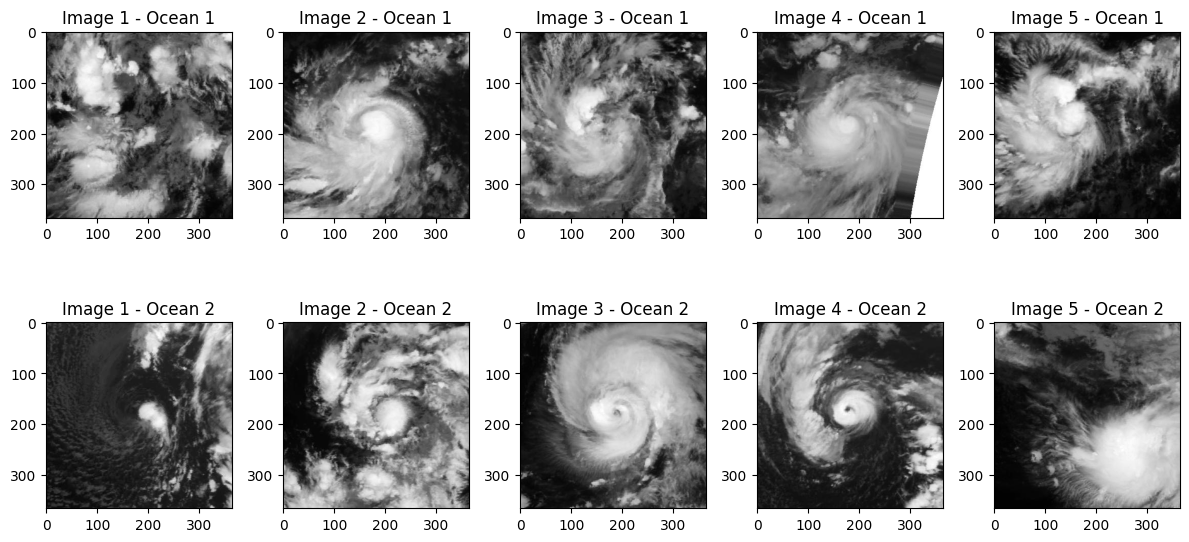

In [23]:
ocean1 = df[df['ocean'] == 1]['img_tensor']
ocean2 = df[df['ocean'] == 2]['img_tensor']
random_ocean1 = np.random.choice(ocean1, size=5, replace=False)
random_ocean2 = np.random.choice(ocean2, size=5, replace=False)

fig, axes = plt.subplots(2, 5, figsize=(12, 6))

for i in range(5):
    axes[0, i].imshow(np.squeeze(random_ocean1[i]), cmap='gray')
    axes[1, i].imshow(np.squeeze(random_ocean2[i]), cmap='gray')

# Add titles
for i in range(5):
    axes[0, i].set_title(f'Image {i+1} - Ocean 1')
    axes[1, i].set_title(f'Image {i+1} - Ocean 2')

plt.tight_layout()

Although average wind speed in ocean 1 is lower than it in ocean 2, the difference is acceptable, and the storm looks similar in two oceans (including clockwise rotation). Therefore, we will not handle them in different oceans.

## storm type

ing    498
eoi    488
wsy    477
gic    467
ipa    449
ojv    420
bkh    410
zny    402
psz    379
dzw    367
mtw    350
hig    342
gkf    340
fna    326
xjo    317
kqu    308
rml    265
qpq    259
ztb    258
blq    252
vye    249
fgi    249
sxb    243
pjj    235
pvj    232
vxf    227
gme    209
yfn    181
woc    173
ywf    155
Name: storm, dtype: int64


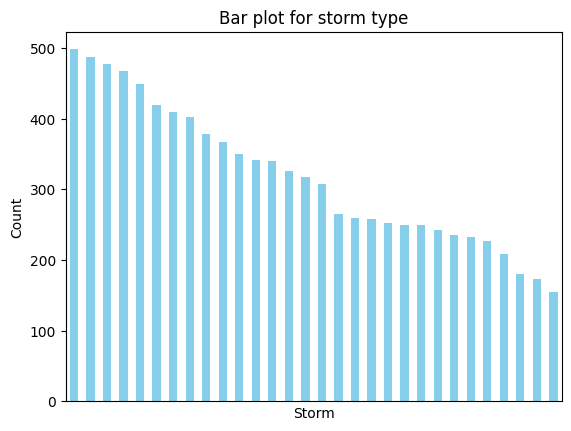

In [31]:
storm_type = df['storm'].value_counts()
print(storm_type)

ax = storm_type.plot(kind='bar', rot=0, color='skyblue')

# Add labels and title
ax.set_xlabel('Storms')
ax.set_ylabel('Count')
ax.set_title('Bar plot for storm type')

# Remove x-axis ticks
ax.set_xticks([])

# Show the plot
plt.show()

## Wind Speed

Text(0.5, 1.0, 'Distribution of Wind Speeds')

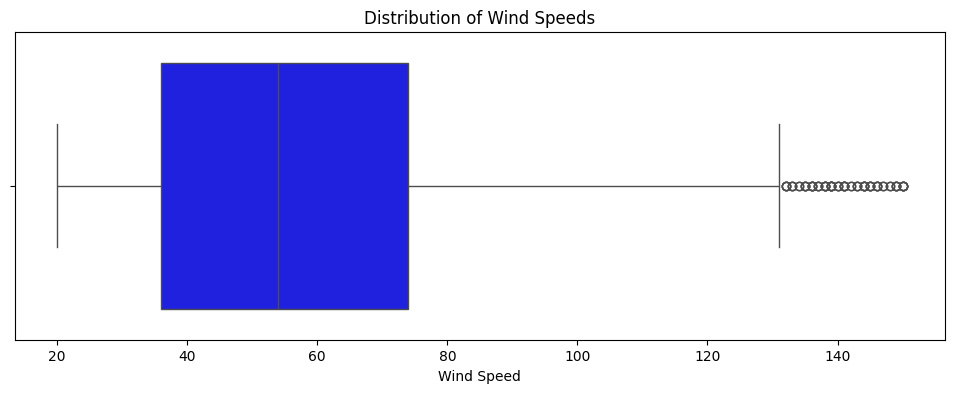

In [38]:
import seaborn as sns

plt.figure(figsize=(12, 4))
sns.boxplot(x=df.wind_speed, color="blue")
plt.xlabel("Wind Speed")
plt.title("Distribution of Wind Speeds")

Check the bias belongs to which storm

In [41]:
df[df['wind_speed']>130]['storm'].value_counts()

psz    62
wsy    11
Name: storm, dtype: int64

Since only two storms contains the moment that the speed is higher than 130, it reasonable to get this data

Let's have a look at the image of different speed

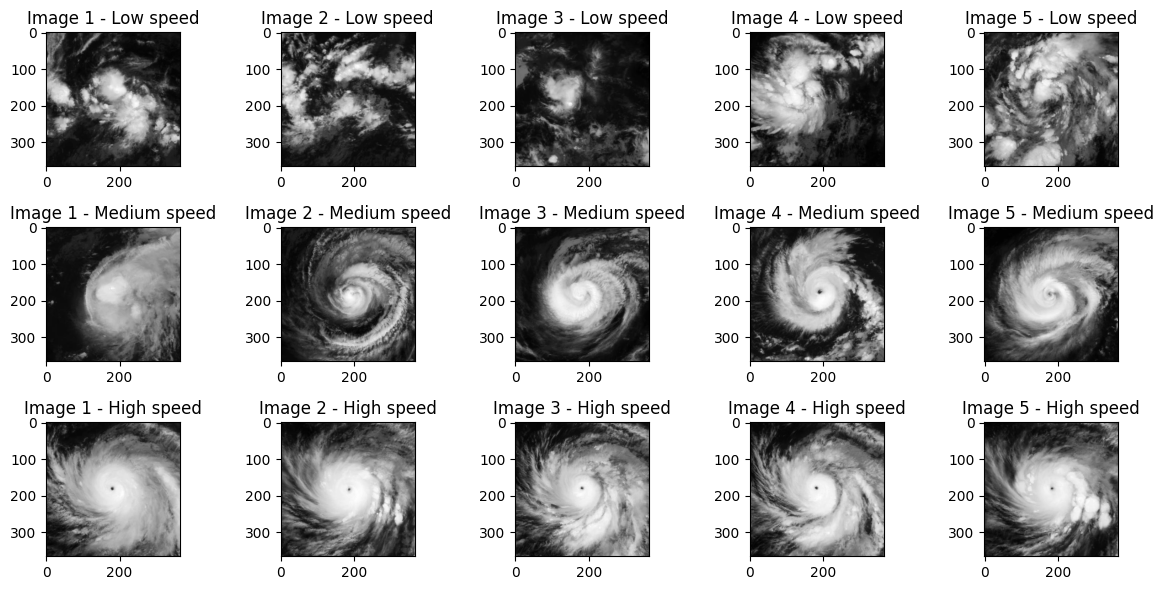

In [45]:
low_speed = df[df['wind_speed'] <= 30]['img_tensor']
medium_speed = df[(df['wind_speed'] >= 70) & (df['wind_speed'] <= 100)]['img_tensor']
high_speed = df[df['wind_speed'] >= 140]['img_tensor']
random_speed1 = np.random.choice(low_speed, size=5, replace=False)
random_speed2 = np.random.choice(medium_speed, size=5, replace=False)
random_speed3 = np.random.choice(high_speed, size=5, replace=False)

fig, axes = plt.subplots(3, 5, figsize=(12, 6))

for i in range(5):
    axes[0, i].imshow(np.squeeze(random_speed1[i]), cmap='gray')
    axes[1, i].imshow(np.squeeze(random_speed2[i]), cmap='gray')
    axes[2, i].imshow(np.squeeze(random_speed3[i]), cmap='gray')

# Add titles
for i in range(5):
    axes[0, i].set_title(f'Image {i+1} - Low speed')
    axes[1, i].set_title(f'Image {i+1} - Medium speed')
    axes[2, i].set_title(f'Image {i+1} - High speed')

plt.tight_layout()

The difference of image between speeds are significant.

We still want to check the speed related with time

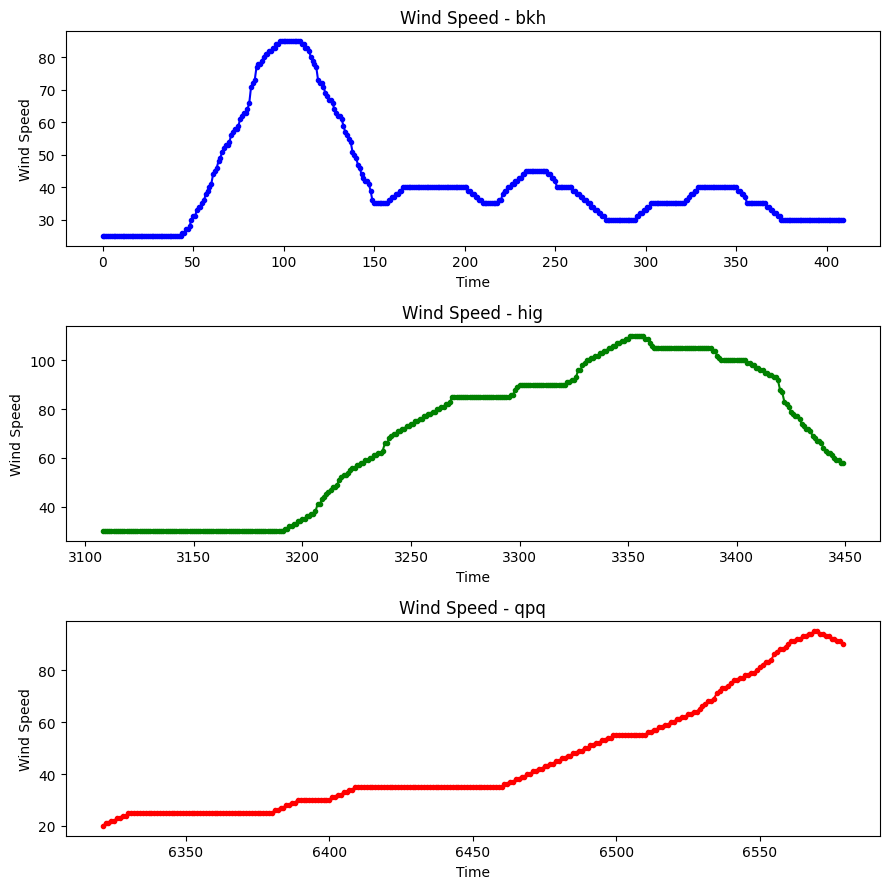

In [51]:
bkh = df[df['storm'] == 'bkh']['wind_speed']
hig = df[df['storm'] == 'hig']['wind_speed']
qpq = df[df['storm'] == 'qpq']['wind_speed']

# Create subplots
fig, axes = plt.subplots(3, 1, figsize=(9, 9))

# Plot wind speed for df1
axes[0].plot(bkh, marker='.', linestyle='-', color='b')
axes[0].set_title('Wind Speed - bkh')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Wind Speed')

axes[1].plot(hig, marker='.', linestyle='-', color='g')
axes[1].set_title('Wind Speed - hig')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Wind Speed')

axes[2].plot(qpq, marker='.', linestyle='-', color='r')
axes[2].set_title('Wind Speed - qpq')
axes[2].set_xlabel('Time')
axes[2].set_ylabel('Wind Speed')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

If we doing a moving average to smooth data and reduce the noise, we get

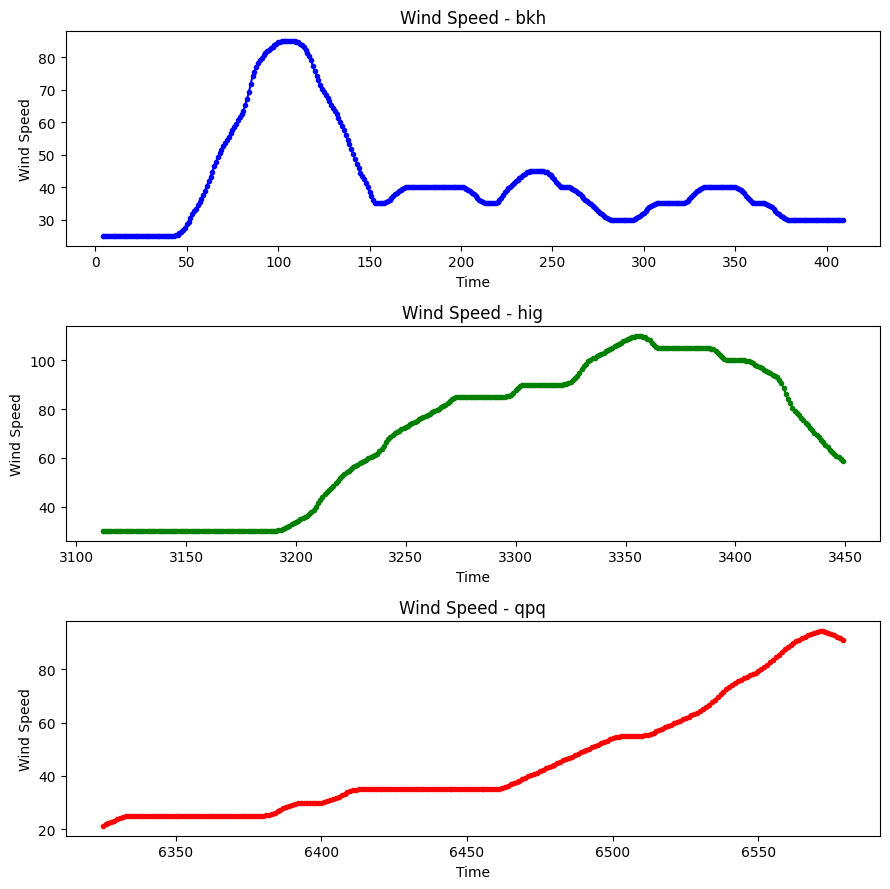

In [52]:
window_size = 5

bkh_mv5 = bkh.rolling(window=window_size).mean()
hig_mv5 = hig.rolling(window=window_size).mean()
qpq_mv5 = qpq.rolling(window=window_size).mean()

# Create subplots
fig, axes = plt.subplots(3, 1, figsize=(9, 9))

# Plot wind speed for df1
axes[0].plot(bkh_mv5, marker='.', linestyle='-', color='b')
axes[0].set_title('Wind Speed - bkh')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Wind Speed')

axes[1].plot(hig_mv5, marker='.', linestyle='-', color='g')
axes[1].set_title('Wind Speed - hig')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Wind Speed')

axes[2].plot(qpq_mv5, marker='.', linestyle='-', color='r')
axes[2].set_title('Wind Speed - qpq')
axes[2].set_xlabel('Time')
axes[2].set_ylabel('Wind Speed')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

## Timestamp

In [79]:
df['time_diff'] = df.groupby('storm')['relative_time'].diff()

# Display value counts
time_diff = df['time_diff'].value_counts()
print(time_diff)


1800.0     4175
3600.0     1381
1799.0     1274
1801.0     1169
3599.0      357
3601.0      337
1802.0      268
1798.0      151
3598.0      107
3602.0       75
12600.0      28
8998.0       27
3603.0       21
8999.0       15
1803.0       14
1797.0       12
7200.0       10
10800.0       8
10799.0       6
12601.0       6
3597.0        5
5399.0        4
12599.0       3
3596.0        3
10798.0       2
2700.0        2
1805.0        2
4500.0        2
5398.0        2
7198.0        2
5397.0        2
9002.0        2
23400.0       1
9028.0        1
9000.0        1
34201.0       1
27000.0       1
28800.0       1
19799.0       1
1593.0        1
2007.0        1
19800.0       1
12598.0       1
45001.0       1
2205.0        1
1395.0        1
7202.0        1
7199.0        1
1804.0        1
28798.0       1
1689.0        1
3711.0        1
5401.0        1
10802.0       1
3297.0        1
61500.0       1
1772.0        1
Name: time_diff, dtype: int64


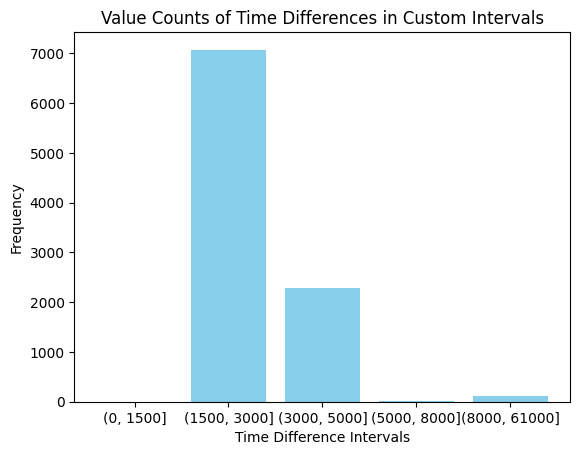

In [64]:
custom_intervals = [0, 1500, 3000, 5000, 8000, 61000]

df1 = df.copy()
# Create intervals and count occurrences
df1['time_diff_interval'] = pd.cut(df1['time_diff'], bins=custom_intervals)
value_counts_intervals = df1['time_diff_interval'].value_counts(sort=False)

# Plot bar chart
plt.bar(value_counts_intervals.index.astype(str), value_counts_intervals.values, color='skyblue')
plt.xlabel('Time Difference Intervals')
plt.ylabel('Frequency')
plt.title('Value Counts of Time Differences in Custom Intervals')
plt.show()

We can see most time interval is lower than 5000, we need to check where the large interval comes from firstly

In [74]:
storm_counts = df1[df1['time_diff'] > 5000]['storm'].value_counts()
storm_counts

dzw    25
bkh    24
hig    23
sxb    20
blq    15
ywf     9
wsy     4
yfn     4
vye     3
eoi     2
gic     1
ipa     1
rml     1
zny     1
Name: storm, dtype: int64

In [73]:
# The percentage of the large time interval accounts
(storm_counts / storm_counts.sum()) * 100

dzw    18.796992
bkh    18.045113
hig    17.293233
sxb    15.037594
blq    11.278195
ywf     6.766917
wsy     3.007519
yfn     3.007519
vye     2.255639
eoi     1.503759
gic     0.751880
ipa     0.751880
rml     0.751880
zny     0.751880
Name: storm, dtype: float64

In summary, the percentages in all storms are lower than 25. Thus, when dealing with data, we can delete all time intervals that are larger than 5000s.